# Imports

In [1]:
%pip install tensorflow_addons

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import os

# Load Dataset

Create training and testing data generators

In [7]:
dataset_dir = 'ebay_images/'
model_dir = 'saved_models/coin_classifier/'
tflite_dir = 'saved_models/coin_classifier.tflite'

batch_size = 64
img_dim = 224
img_size = (img_dim, img_dim)
img_shape = (img_dim, img_dim, 3)
seed = 1234

train_datagen = ImageDataGenerator(
  height_shift_range=0.1,
  width_shift_range=0.1,
  rotation_range=45,
  brightness_range=(0.8, 1.2),
  rescale=1./255,
  validation_split=0.2,
)
test_datagen = ImageDataGenerator(
  rescale=1./255,
  validation_split=0.2,
)

train_generator = train_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='training',
  seed=seed,
)
test_generator = test_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='validation',
  shuffle=False,
  seed=seed,
)

labels = list(train_generator.class_indices.keys())
class_count = len(labels)

Found 25476 images belonging to 42 classes.
Found 6348 images belonging to 42 classes.


Display coin images

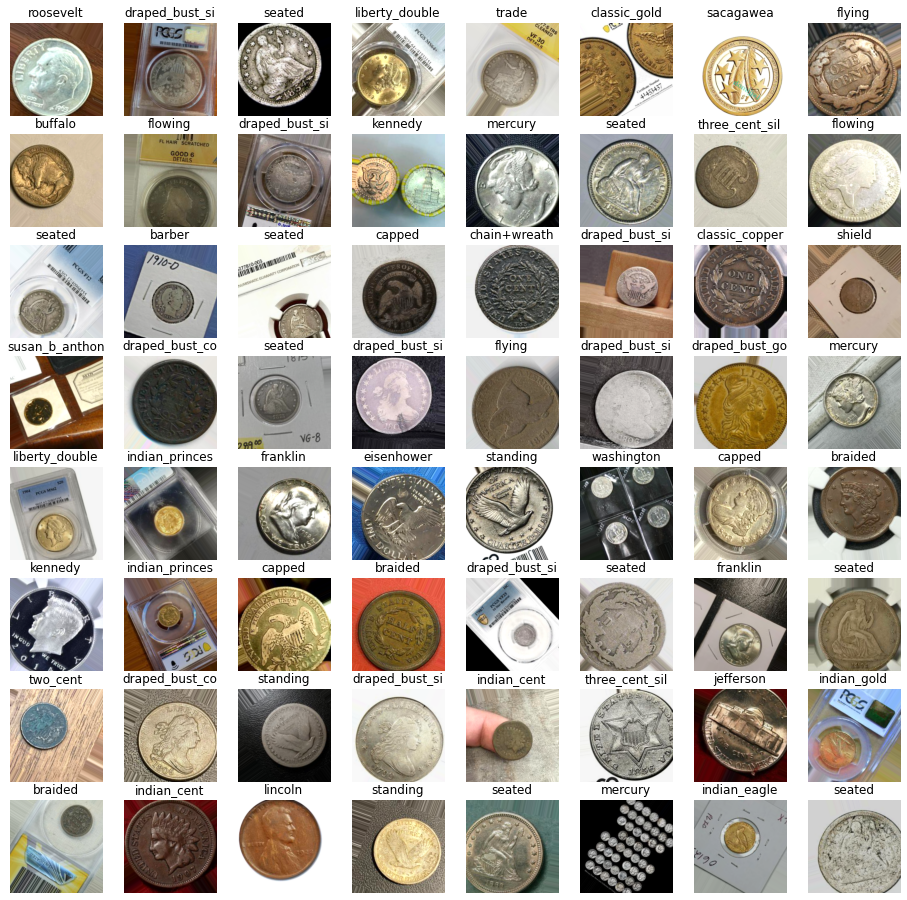

In [8]:
fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = train_generator.next()
for i in range(min(len(X_batch), 64)):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  plt.title(labels[np.argmax(y_batch[i])][:14])

# Training

Create coin classifier model using ResNet50 architecture

In [11]:
coin_classifier = ResNet50V2(classes=class_count, weights=None)
trainable_param_count = np.sum([np.prod(layer.shape) for layer in coin_classifier.trainable_weights])
nontrainable_param_count = np.sum([np.prod(layer.shape) for layer in coin_classifier.non_trainable_weights])
print('>>>> ResNet50 Model Summary <<<<')
print(f'Input shape: {coin_classifier.input.shape[1:]}')
print(f'Output shape: {coin_classifier.output.shape[1:]}')
print(f'Number of layers: {len(coin_classifier.layers)}')
print(f'Number of trainable parameters: {trainable_param_count}')
print(f'Number of non-trainable parameters: {nontrainable_param_count}')
print(f'Total number of parameters: {trainable_param_count+nontrainable_param_count}')

>>>> ResNet50 Model Summary <<<<
Input shape: (224, 224, 3)
Output shape: (42,)
Number of layers: 192
Number of trainable parameters: 23605418
Number of non-trainable parameters: 45440
Total number of parameters: 23650858


Train coin classifier

In [12]:
coin_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', F1Score(class_count)])
history = coin_classifier.fit(
  train_generator,
  callbacks=[
    EarlyStopping(monitor='val_accuracy', patience=20),
    ModelCheckpoint('checkpoint', monitor='val_accuracy', save_best_only=True),
  ],
  validation_data=test_generator,
  epochs=100,
)
coin_classifier = load_model('checkpoint')

Epoch 1/100
399/399 [==============================] - 441s 1s/step - loss: 3.1626 - accuracy: 0.1410 - f1_score: 0.0525 - val_loss: 3.1175 - val_accuracy: 0.1411 - val_f1_score: 0.0424
Epoch 2/100
399/399 [==============================] - 407s 1s/step - loss: 2.8829 - accuracy: 0.1769 - f1_score: 0.0799 - val_loss: 3.4175 - val_accuracy: 0.1274 - val_f1_score: 0.0419
Epoch 3/100
399/399 [==============================] - 431s 1s/step - loss: 2.7407 - accuracy: 0.2080 - f1_score: 0.1095 - val_loss: 2.8911 - val_accuracy: 0.1925 - val_f1_score: 0.0747
Epoch 4/100
399/399 [==============================] - 408s 1s/step - loss: 2.5934 - accuracy: 0.2414 - f1_score: 0.1392 - val_loss: 3.2578 - val_accuracy: 0.1534 - val_f1_score: 0.0727
Epoch 5/100
399/399 [==============================] - 404s 1s/step - loss: 2.4368 - accuracy: 0.2786 - f1_score: 0.1764 - val_loss: 3.5700 - val_accuracy: 0.1594 - val_f1_score: 0.0834
Epoch 6/100
399/399 [==============================] - 430s 1s/step - 

Save training metrics

In [13]:
if not os.path.isdir('metrics'):
  os.mkdir('metrics')

train_losses = history.history['loss']
train_accuracies = history.history['accuracy']
train_f1_scores = history.history['f1_score']

test_losses = history.history['val_loss']
test_accuracies = history.history['val_accuracy']
test_f1_scores = history.history['val_f1_score']

np.save('metrics/train_losses.npy', train_losses)
np.save('metrics/train_accuracies.npy', train_accuracies)
np.save('metrics/train_f1_scores.npy', train_f1_scores)

np.save('metrics/test_losses.npy', test_losses)
np.save('metrics/test_accuracies.npy', test_accuracies)
np.save('metrics/test_f1_scores.npy', test_f1_scores)

# Evaluation

Plot training and validation accuracies

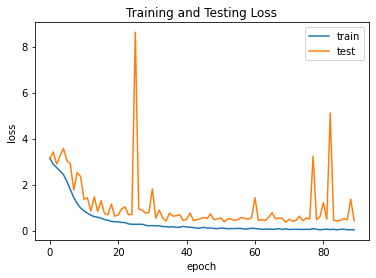

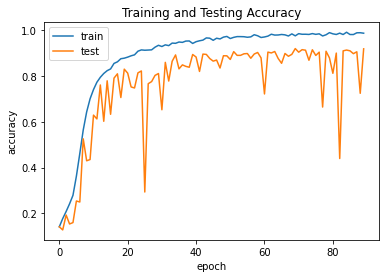

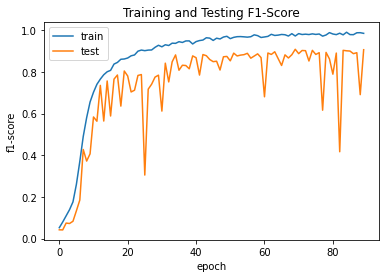

In [15]:
# plot losses
plt.plot(train_losses)
plt.plot(test_losses)
plt.title('Training and Testing Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

# plot accuracies
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.title('Training and Testing Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()

# plot f1 scores
plt.plot(np.mean(train_f1_scores, axis=1))
plt.plot(np.mean(test_f1_scores, axis=1))
plt.title('Training and Testing F1-Score')
plt.xlabel('epoch')
plt.ylabel('f1-score')
plt.legend(['train', 'test'])
plt.show()

Plot confusion matrix

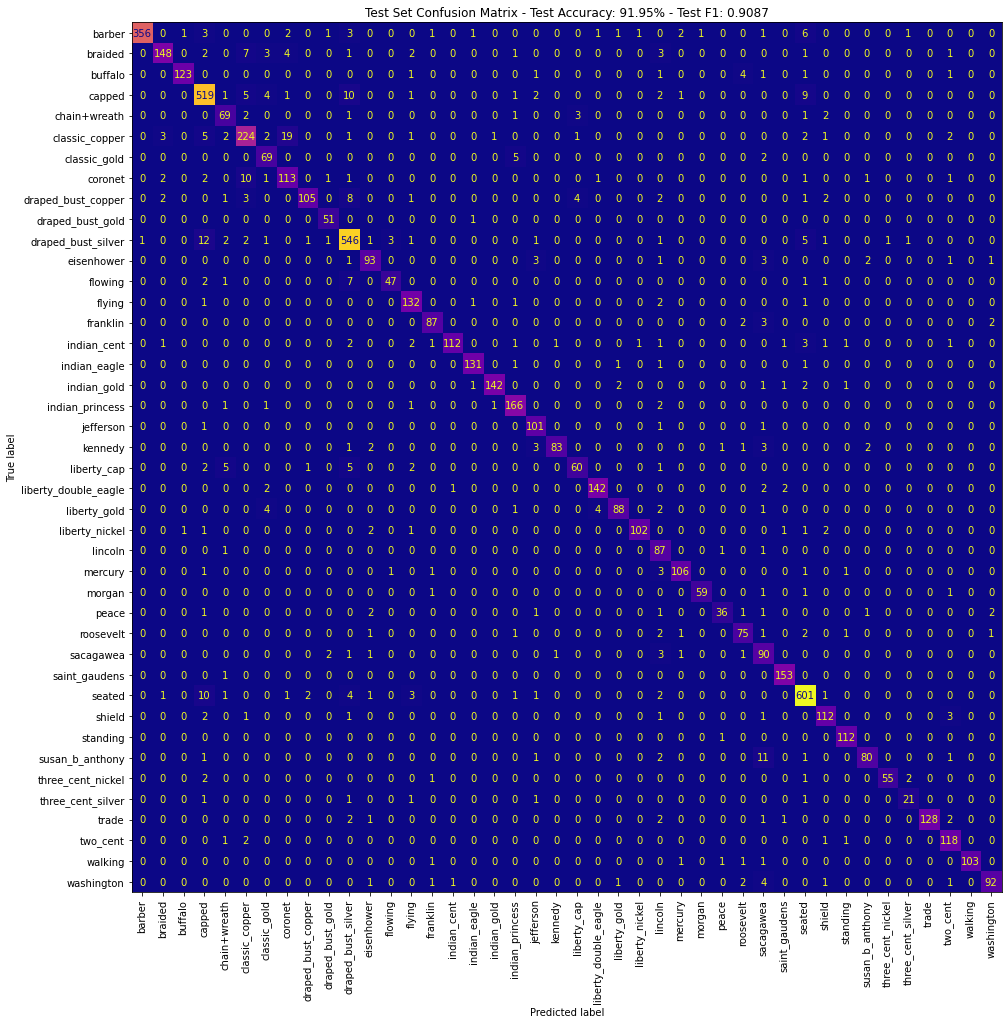

In [16]:
predictions = list(np.argmax(coin_classifier.predict(test_generator), axis=1))
true = list(test_generator.labels)

fig, ax = plt.subplots(figsize=(16, 16))
accuracy = round(accuracy_score(true, predictions) * 100, 2)
f1 = round(f1_score(true, predictions, average='macro'), 4)

conf_matrix = confusion_matrix(true, predictions)

ConfusionMatrixDisplay(conf_matrix, display_labels=labels).plot(
  xticks_rotation='vertical',
  cmap='plasma',
  ax=ax,
  colorbar=False,
)

plt.title(f'Test Set Confusion Matrix - Test Accuracy: {accuracy}% - Test F1: {f1}')
plt.show()

Print per-class metrics

In [17]:
sort_by = 'recall'

precisions = precision_score(true, predictions, average=None)
recalls = recall_score(true, predictions, average=None)
f1_scores = f1_score(true, predictions, average=None)

if sort_by == 'precision':
  sorted_metric = sorted(enumerate(precisions), key=lambda x: x[1], reverse=True)
elif sort_by == 'recall':
  sorted_metric = sorted(enumerate(recalls), key=lambda x: x[1], reverse=True)
else:
   sorted_metric = sorted(enumerate(f1_scores), key=lambda x: x[1], reverse=True)

def get_mistakes(class_index):
  false_positives = sorted(enumerate(conf_matrix[:,class_index]), key=lambda x: x[1], reverse=True)
  false_negatives = sorted(enumerate(conf_matrix[class_index]), key=lambda x: x[1], reverse=True)
  false_positives = [(labels[i], count) for i, count in false_positives if count > 0 and i != class_index]
  false_negatives = [(labels[i], count) for i, count in false_negatives if count > 0 and i != class_index]
  return false_positives, false_negatives

for i, metric in sorted_metric:
  recall = metric if sort_by == 'recall' else recalls[i]
  precision = metric if sort_by == 'precision' else precisions[i]
  f1 = metric if sort_by == 'f1_score' else f1_scores[i]
  false_positives, false_negatives = get_mistakes(i)
  print(f'>>>> {labels[i]} <<<<')
  print(f'Precision: {round(precision * 100, 2)}%')
  print(f'Recall: {round(recall * 100, 2)}%')
  print(f'F1 Score: {round(f1, 4)}')
  print(f'False Positives: {false_positives}')
  print(f'False Negatives: {false_negatives}')
  print()

>>>> saint_gaudens <<<<
Precision: 96.23%
Recall: 99.35%
F1 Score: 0.9776
False Positives: [('liberty_double_eagle', 2), ('indian_cent', 1), ('indian_gold', 1), ('liberty_nickel', 1), ('trade', 1)]
False Negatives: [('chain+wreath', 1)]

>>>> standing <<<<
Precision: 95.73%
Recall: 99.12%
F1 Score: 0.9739
False Positives: [('indian_cent', 1), ('indian_gold', 1), ('mercury', 1), ('roosevelt', 1), ('two_cent', 1)]
False Negatives: [('peace', 1)]

>>>> draped_bust_gold <<<<
Precision: 91.07%
Recall: 98.08%
F1 Score: 0.9444
False Positives: [('sacagawea', 2), ('barber', 1), ('coronet', 1), ('draped_bust_silver', 1)]
False Negatives: [('indian_eagle', 1)]

>>>> jefferson <<<<
Precision: 87.83%
Recall: 97.12%
F1 Score: 0.9224
False Positives: [('eisenhower', 3), ('kennedy', 3), ('capped', 2), ('buffalo', 1), ('draped_bust_silver', 1), ('peace', 1), ('seated', 1), ('susan_b_anthony', 1), ('three_cent_silver', 1)]
False Negatives: [('capped', 1), ('lincoln', 1), ('sacagawea', 1)]

>>>> indian_

Predict images in test set

Found 6348 images belonging to 42 classes.


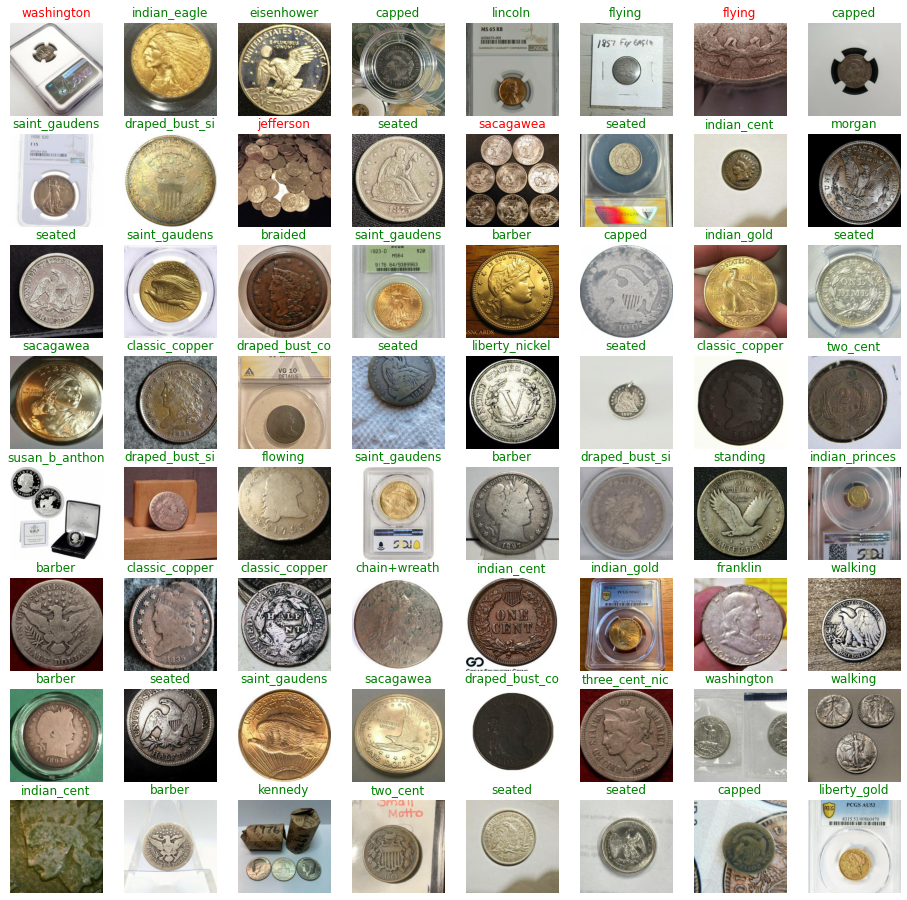

In [22]:
test_generator_shuffled = test_datagen.flow_from_directory(
  dataset_dir,
  target_size=img_size,
  batch_size=batch_size,
  subset='validation',
  seed=seed,
)

fig = plt.figure(figsize=(16, 16))
X_batch, y_batch = test_generator_shuffled.next()
predictions = coin_classifier.predict(X_batch)
for i in range(min(len(X_batch), 64)):
  fig.add_subplot(8, 8, i + 1)
  plt.imshow(X_batch[i])
  plt.axis('off')
  title_obj = plt.title(labels[np.argmax(predictions[i])][:14])
  plt.setp(title_obj, color='g' if np.argmax(predictions[i]) == np.argmax(y_batch[i]) else 'r')

# Save Classifier

Save classifier normally

In [20]:
coin_classifier.save(model_dir)

INFO:tensorflow:Assets written to: saved_models/coin_classifier/assets


Save classifier using tflite format

In [21]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_dir)
tflite_model = converter.convert()
with open(tflite_dir, 'wb') as f:
  f.write(tflite_model)